In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as LR

import torchvision
import torchvision.transforms as transforms

In [2]:
class NN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(NN, self).__init__()
        
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))

    def forward(self, x):
        return x
    
    def update(self, u, v, eta=None):
        pass
    


class Adam(nn.Module):
    def __init__(self, param, betas=(0.9, 0.999), eps=1e-8):
        super(Adam, self).__init__()

        self.register_buffer('beta1', torch.tensor(betas[0]))
        self.register_buffer('beta2', torch.tensor(betas[1]))
        self.register_buffer('eps', torch.tensor(eps))

        self.register_buffer('m', torch.zeros_like(param))
        self.register_buffer('v', torch.zeros_like(param))
        self.register_buffer('t', torch.tensor(0.0))

    def forward(self, g):
        self.m = self.beta1 * self.m + (1-self.beta1) * g
        self.v = self.beta2 * self.v + (1-self.beta2) * g**2
        self.t += 1

        m_hat = self.m/(1 - self.beta1**self.t)
        v_hat = self.v/(1 - self.beta2**self.t)

        return m_hat / (torch.sqrt(v_hat) + self.eps)


class IP(nn.Module):
    def __init__(self, layersize, eta=1):
        super(IP, self).__init__()
        self.eta = eta
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
        self.adjust_a = Adam(self.alpha)
        self.adjust_b = Adam(self.beta)
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        return  nx
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Ev = v.mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = self.alpha + eta*self.adjust_a(2*Euv)
        self.beta = self.beta + eta*self.adjust_b(Ev)
#         for n in self.alpha:
#             for gain in n:
#                 if(gain != abs(gain)):
#                     print("FLAG!")
        
#         self.eta = eta * 0.999


class DNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(DNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(28*28, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 28*28)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = F.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = F.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = F.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = F.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = F.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = F.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        return o

In [3]:
class CDNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(CDNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(3*32*32, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 3*32*32)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = F.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = F.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = F.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = F.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = F.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = F.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        return o

In [4]:
def train_deep_model(network, optimization, seed, epochs):
    
    criterion = nn.CrossEntropyLoss()
    torch.manual_seed(seed)
    
    loss_tracker = []
    episode = 1
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        i = 0
        
        for i, data in enumerate(trainloader):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimization.zero_grad()

            # forward + backward + optimize
            y = network(inputs)
            loss = criterion(y, labels)
            loss.backward()
            optimization.step()

            # update statistics
            running_loss += loss.item()
            i += 0
            
            loss_tracker.append([episode,loss.item()])
            episode += 1
            
        print('[%d] loss: %.3f' %
                      (epoch + 1,running_loss / i))
    
#     print(abs(network.n1.beta.max(0)[0]).max(0))
    print("Largest beta is ", max(abs(network.n1.beta.max(0)[0]).max(0),
                   abs(network.n2.beta.max(0)[0]).max(0),
                   abs(network.n3.beta.max(0)[0]).max(0),
                   abs(network.n4.beta.max(0)[0]).max(0),
                   abs(network.n5.beta.max(0)[0]).max(0),
                   abs(network.n6.beta.max(0)[0]).max(0),
                   abs(network.n7.beta.max(0)[0]).max(0),
                   abs(network.n8.beta.max(0)[0]).max(0)))
    print("Largest weight is ", max(abs(network.fc1.weight.max(0)[0]).max(0),
              abs(network.fc2.weight.max(0)[0]).max(0),
              abs(network.fc3.weight.max(0)[0]).max(0),
              abs(network.fc4.weight.max(0)[0]).max(0),
              abs(network.fc5.weight.max(0)[0]).max(0),
              abs(network.fc6.weight.max(0)[0]).max(0),
              abs(network.fc7.weight.max(0)[0]).max(0),
              abs(network.fc8.weight.max(0)[0]).max(0)))
    
    print("Finished training!\n")
    return(np.transpose(loss_tracker))


def run_cifar_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run 1")
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = CDNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = CDNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for deep networks")
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    
def run_mnist_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run 1")
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = DNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = DNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for deep networks")
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# MNIST Tests

In [5]:
transform = transforms.ToTensor()


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 200

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print('==>>> total training batch number: {}'.format(len(trainloader)))
print('==>>> total testing batch number: {}'.format(len(testloader)))

==>>> total training batch number: 300
==>>> total testing batch number: 50


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50

test_runs = 10
epochs = 20

int_lr = 0.0001

Training IP Net. Run 1
[1] loss: 1.526
[2] loss: 0.549
[3] loss: 0.322
[4] loss: 0.241
[5] loss: 0.196
[6] loss: 0.174
[7] loss: 0.155
[8] loss: 0.140
[9] loss: 0.126
[10] loss: 0.117
[11] loss: 0.106
[12] loss: 0.096
[13] loss: 0.089
[14] loss: 0.087
[15] loss: 0.081
[16] loss: 0.075
[17] loss: 0.074
[18] loss: 0.065
[19] loss: 0.065
[20] loss: 0.061
Largest beta is  (tensor(0.6518, device='cuda:0'), tensor(48, device='cuda:0'))
Largest weight is  (tensor(0.9009, device='cuda:0'), tensor(2, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 1.423
[2] loss: 0.488
[3] loss: 0.293
[4] loss: 0.225
[5] loss: 0.187
[6] loss: 0.159
[7] loss: 0.139
[8] loss: 0.122
[9] loss: 0.113
[10] loss: 0.099
[11] loss: 0.095
[12] loss: 0.088
[13] loss: 0.077
[14] loss: 0.073
[15] loss: 0.069
[16] loss: 0.063
[17] loss: 0.059
[18] loss: 0.055
[19] loss: 0.054
[20] loss: 0.048
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.7

[9] loss: 0.115
[10] loss: 0.100
[11] loss: 0.091
[12] loss: 0.083
[13] loss: 0.076
[14] loss: 0.070
[15] loss: 0.069
[16] loss: 0.060
[17] loss: 0.055
[18] loss: 0.056
[19] loss: 0.050
[20] loss: 0.048
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.6808, device='cuda:0'), tensor(304, device='cuda:0'))
Finished training!

Training IP Net. Run 9
[1] loss: 1.595
[2] loss: 0.979
[3] loss: 0.331
[4] loss: 0.236
[5] loss: 0.188
[6] loss: 0.159
[7] loss: 0.138
[8] loss: 0.124
[9] loss: 0.111
[10] loss: 0.104
[11] loss: 0.096
[12] loss: 0.088
[13] loss: 0.081
[14] loss: 0.075
[15] loss: 0.074
[16] loss: 0.067
[17] loss: 0.063
[18] loss: 0.063
[19] loss: 0.060
[20] loss: 0.052
Largest beta is  (tensor(0.6416, device='cuda:0'), tensor(13, device='cuda:0'))
Largest weight is  (tensor(0.9391, device='cuda:0'), tensor(4, device='cuda:0'))
Finished training!

Training Standard Net. Run 9
[1] loss: 1.591
[2] loss: 0.695
[3] loss: 0.290
[4] los

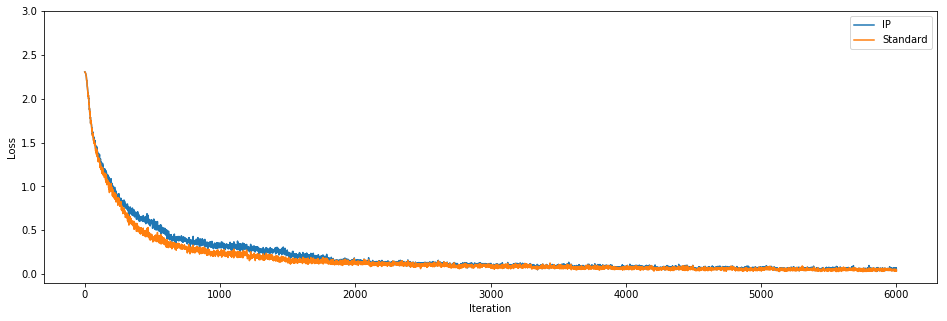

In [7]:
syn_lr = 0.001

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 1.037
[2] loss: 0.454
[3] loss: 0.270
[4] loss: 0.199
[5] loss: 0.168
[6] loss: 0.140
[7] loss: 0.120
[8] loss: 0.105
[9] loss: 0.099
[10] loss: 0.091
[11] loss: 0.081
[12] loss: 0.076
[13] loss: 0.072
[14] loss: 0.066
[15] loss: 0.059
[16] loss: 0.057
[17] loss: 0.056
[18] loss: 0.052
[19] loss: 0.047
[20] loss: 0.045
Largest beta is  (tensor(0.6386, device='cuda:0'), tensor(16, device='cuda:0'))
Largest weight is  (tensor(1.5219, device='cuda:0'), tensor(303, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 1.032
[2] loss: 0.478
[3] loss: 0.277
[4] loss: 0.215
[5] loss: 0.177
[6] loss: 0.149
[7] loss: 0.134
[8] loss: 0.121
[9] loss: 0.109
[10] loss: 0.099
[11] loss: 0.093
[12] loss: 0.092
[13] loss: 0.086
[14] loss: 0.081
[15] loss: 0.075
[16] loss: 0.073
[17] loss: 0.067
[18] loss: 0.069
[19] loss: 0.066
[20] loss: 0.067
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(1

[8] loss: 0.109
[9] loss: 0.106
[10] loss: 0.092
[11] loss: 0.091
[12] loss: 0.084
[13] loss: 0.077
[14] loss: 0.082
[15] loss: 0.076
[16] loss: 0.069
[17] loss: 0.072
[18] loss: 0.067
[19] loss: 0.061
[20] loss: 0.065
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(1.5155, device='cuda:0'), tensor(580, device='cuda:0'))
Finished training!

Training IP Net. Run 9
[1] loss: 1.136
[2] loss: 0.452
[3] loss: 0.279
[4] loss: 0.207
[5] loss: 0.178
[6] loss: 0.143
[7] loss: 0.127
[8] loss: 0.106
[9] loss: 0.099
[10] loss: 0.091
[11] loss: 0.087
[12] loss: 0.074
[13] loss: 0.069
[14] loss: 0.065
[15] loss: 0.064
[16] loss: 0.055
[17] loss: 0.056
[18] loss: 0.049
[19] loss: 0.051
[20] loss: 0.044
Largest beta is  (tensor(0.6529, device='cuda:0'), tensor(2, device='cuda:0'))
Largest weight is  (tensor(1.5724, device='cuda:0'), tensor(314, device='cuda:0'))
Finished training!

Training Standard Net. Run 9
[1] loss: 1.099
[2] loss: 0.386
[3] lo

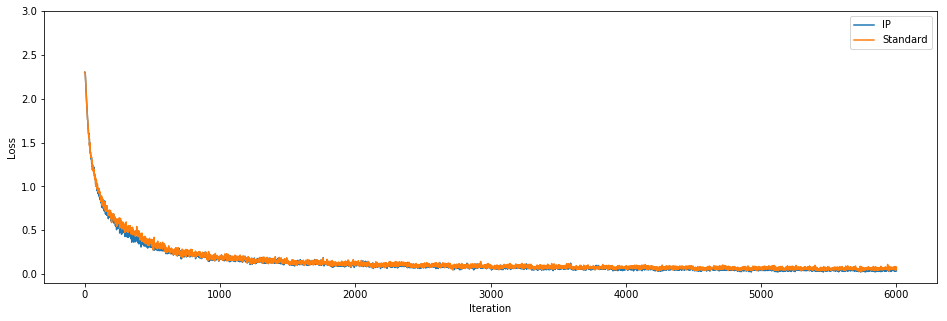

In [8]:
syn_lr = 0.003

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 0.975
[2] loss: 0.551
[3] loss: 0.377
[4] loss: 0.306
[5] loss: 0.289
[6] loss: 0.269
[7] loss: 0.250
[8] loss: 0.231
[9] loss: 0.224
[10] loss: 0.215
[11] loss: 0.221
[12] loss: 0.199
[13] loss: 0.201
[14] loss: 0.200
[15] loss: 0.187
[16] loss: 0.167
[17] loss: 0.155
[18] loss: 0.184
[19] loss: 0.165
[20] loss: 0.157
Largest beta is  (tensor(0.6263, device='cuda:0'), tensor(4, device='cuda:0'))
Largest weight is  (tensor(4.4160, device='cuda:0'), tensor(316, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 1.278
[2] loss: 0.824
[3] loss: 0.470
[4] loss: 0.407
[5] loss: 0.398
[6] loss: 0.378
[7] loss: 0.361
[8] loss: 0.371
[9] loss: 0.349
[10] loss: 0.326
[11] loss: 0.354
[12] loss: 0.365
[13] loss: 0.378
[14] loss: 0.391
[15] loss: 0.399
[16] loss: 0.372
[17] loss: 0.384
[18] loss: 0.396
[19] loss: 0.402
[20] loss: 0.389
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(4.

[8] loss: 0.350
[9] loss: 0.338
[10] loss: 0.363
[11] loss: 0.363
[12] loss: 0.354
[13] loss: 0.348
[14] loss: 0.375
[15] loss: 0.392
[16] loss: 0.410
[17] loss: 0.397
[18] loss: 0.404
[19] loss: 0.407
[20] loss: 0.403
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(4.3672, device='cuda:0'), tensor(39, device='cuda:0'))
Finished training!

Training IP Net. Run 9
[1] loss: 1.129
[2] loss: 0.525
[3] loss: 0.387
[4] loss: 0.324
[5] loss: 0.293
[6] loss: 0.258
[7] loss: 0.273
[8] loss: 0.261
[9] loss: 0.235
[10] loss: 0.236
[11] loss: 0.228
[12] loss: 0.208
[13] loss: 0.212
[14] loss: 0.203
[15] loss: 0.196
[16] loss: 0.199
[17] loss: 0.193
[18] loss: 0.193
[19] loss: 0.195
[20] loss: 0.192
Largest beta is  (tensor(0.6404, device='cuda:0'), tensor(28, device='cuda:0'))
Largest weight is  (tensor(4.4240, device='cuda:0'), tensor(288, device='cuda:0'))
Finished training!

Training Standard Net. Run 9
[1] loss: 1.048
[2] loss: 0.478
[3] lo

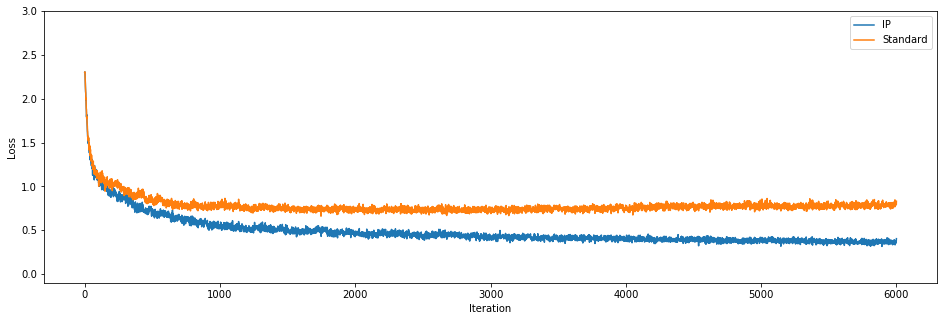

In [9]:
syn_lr = 0.01

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 1.070
[2] loss: 0.720
[3] loss: 0.521
[4] loss: 0.452
[5] loss: 0.409
[6] loss: 0.357
[7] loss: 0.356
[8] loss: 0.345
[9] loss: 0.323
[10] loss: 0.329
[11] loss: 0.300
[12] loss: 0.297
[13] loss: 0.308
[14] loss: 0.292
[15] loss: 0.285
[16] loss: 0.268
[17] loss: 0.276
[18] loss: 0.248
[19] loss: 0.254
[20] loss: 0.235
Largest beta is  (tensor(0.6354, device='cuda:0'), tensor(3, device='cuda:0'))
Largest weight is  (tensor(4.8403, device='cuda:0'), tensor(293, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 1.032
[2] loss: 0.783
[3] loss: 0.620
[4] loss: 0.585
[5] loss: 0.538
[6] loss: 0.495
[7] loss: 0.518
[8] loss: 0.499
[9] loss: 0.513
[10] loss: 0.508
[11] loss: 0.513
[12] loss: 0.558
[13] loss: 0.572
[14] loss: 0.587
[15] loss: 0.525
[16] loss: 0.524
[17] loss: 0.561
[18] loss: 0.550
[19] loss: 0.565
[20] loss: 0.626
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(4.

[9] loss: 0.441
[10] loss: 0.465
[11] loss: 0.473
[12] loss: 0.501
[13] loss: 0.501
[14] loss: 0.560
[15] loss: 0.523
[16] loss: 0.534
[17] loss: 0.531
[18] loss: 0.536
[19] loss: 0.592
[20] loss: 0.623
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(4.2092, device='cuda:0'), tensor(41, device='cuda:0'))
Finished training!

Training IP Net. Run 9
[1] loss: 0.665
[2] loss: 0.441
[3] loss: 0.394
[4] loss: 0.374
[5] loss: 0.332
[6] loss: 0.300
[7] loss: 0.299
[8] loss: 0.272
[9] loss: 0.245
[10] loss: 0.275
[11] loss: 0.254
[12] loss: 0.241
[13] loss: 0.242
[14] loss: 0.244
[15] loss: 0.242
[16] loss: 0.236
[17] loss: 0.242
[18] loss: 0.224
[19] loss: 0.222
[20] loss: 0.206
Largest beta is  (tensor(0.6312, device='cuda:0'), tensor(11, device='cuda:0'))
Largest weight is  (tensor(4.8522, device='cuda:0'), tensor(432, device='cuda:0'))
Finished training!

Training Standard Net. Run 9
[1] loss: 0.685
[2] loss: 0.408
[3] loss: 0.432
[4] lo

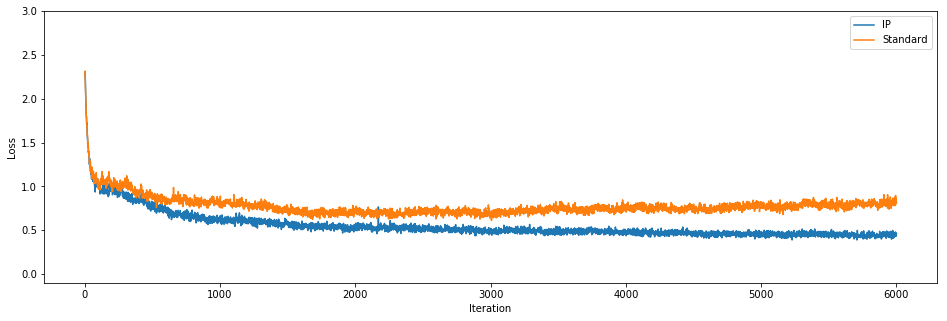

In [10]:
syn_lr = 0.012

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

# CIFAR-10 Tests

In [5]:
batchSize = 200

transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 150
epochs = 40

test_runs = 10

int_lr = 0.0001

Training IP Net. Run 1
[1] loss: 2.069
[2] loss: 1.875
[3] loss: 1.799
[4] loss: 1.746
[5] loss: 1.690
[6] loss: 1.650
[7] loss: 1.607
[8] loss: 1.581
[9] loss: 1.556
[10] loss: 1.528
[11] loss: 1.512
[12] loss: 1.499
[13] loss: 1.475
[14] loss: 1.462
[15] loss: 1.444
[16] loss: 1.436
[17] loss: 1.415
[18] loss: 1.418
[19] loss: 1.394
[20] loss: 1.381
[21] loss: 1.379
[22] loss: 1.364
[23] loss: 1.356
[24] loss: 1.344
[25] loss: 1.344
[26] loss: 1.322
[27] loss: 1.318
[28] loss: 1.315
[29] loss: 1.308
[30] loss: 1.297
[31] loss: 1.290
[32] loss: 1.289
[33] loss: 1.288
[34] loss: 1.269
[35] loss: 1.273
[36] loss: 1.261
[37] loss: 1.261
[38] loss: 1.240
[39] loss: 1.242
[40] loss: 1.238
Largest beta is  (tensor(1.1284, device='cuda:0'), tensor(131, device='cuda:0'))
Largest weight is  (tensor(0.3945, device='cuda:0'), tensor(122, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 2.100
[2] loss: 1.860
[3] loss: 1.780
[4] loss: 1.718
[5] loss: 1.667
[6] loss: 1.6

[18] loss: 1.327
[19] loss: 1.319
[20] loss: 1.301
[21] loss: 1.286
[22] loss: 1.270
[23] loss: 1.246
[24] loss: 1.244
[25] loss: 1.228
[26] loss: 1.223
[27] loss: 1.209
[28] loss: 1.187
[29] loss: 1.175
[30] loss: 1.167
[31] loss: 1.157
[32] loss: 1.150
[33] loss: 1.131
[34] loss: 1.121
[35] loss: 1.117
[36] loss: 1.095
[37] loss: 1.096
[38] loss: 1.088
[39] loss: 1.070
[40] loss: 1.080
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.2561, device='cuda:0'), tensor(67, device='cuda:0'))
Finished training!

Training IP Net. Run 6
[1] loss: 2.038
[2] loss: 1.871
[3] loss: 1.795
[4] loss: 1.748
[5] loss: 1.707
[6] loss: 1.669
[7] loss: 1.627
[8] loss: 1.585
[9] loss: 1.564
[10] loss: 1.537
[11] loss: 1.508
[12] loss: 1.495
[13] loss: 1.475
[14] loss: 1.462
[15] loss: 1.441
[16] loss: 1.431
[17] loss: 1.406
[18] loss: 1.400
[19] loss: 1.385
[20] loss: 1.381
[21] loss: 1.374
[22] loss: 1.362
[23] loss: 1.349
[24] loss: 1.339
[25] loss:

[37] loss: 1.257
[38] loss: 1.239
[39] loss: 1.235
[40] loss: 1.235
Largest beta is  (tensor(1.1380, device='cuda:0'), tensor(53, device='cuda:0'))
Largest weight is  (tensor(0.4211, device='cuda:0'), tensor(75, device='cuda:0'))
Finished training!

Training Standard Net. Run 10
[1] loss: 2.087
[2] loss: 1.910
[3] loss: 1.831
[4] loss: 1.736
[5] loss: 1.663
[6] loss: 1.620
[7] loss: 1.577
[8] loss: 1.555
[9] loss: 1.522
[10] loss: 1.486
[11] loss: 1.463
[12] loss: 1.448
[13] loss: 1.420
[14] loss: 1.406
[15] loss: 1.386
[16] loss: 1.375
[17] loss: 1.351
[18] loss: 1.333
[19] loss: 1.324
[20] loss: 1.304
[21] loss: 1.298
[22] loss: 1.276
[23] loss: 1.277
[24] loss: 1.249
[25] loss: 1.249
[26] loss: 1.233
[27] loss: 1.223
[28] loss: 1.218
[29] loss: 1.197
[30] loss: 1.181
[31] loss: 1.175
[32] loss: 1.164
[33] loss: 1.155
[34] loss: 1.148
[35] loss: 1.131
[36] loss: 1.126
[37] loss: 1.124
[38] loss: 1.106
[39] loss: 1.092
[40] loss: 1.091
Largest beta is  (tensor(0., device='cuda:0'), te

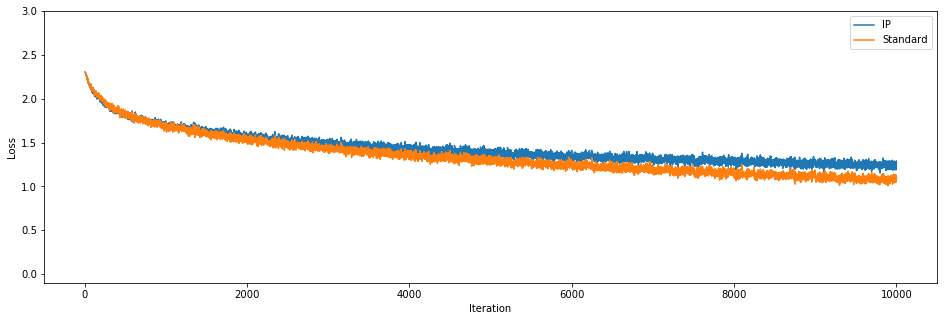

In [13]:
syn_lr = 0.0003

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 2.026
[2] loss: 1.836
[3] loss: 1.779
[4] loss: 1.727
[5] loss: 1.677
[6] loss: 1.652
[7] loss: 1.619
[8] loss: 1.589
[9] loss: 1.558
[10] loss: 1.542
[11] loss: 1.513
[12] loss: 1.504
[13] loss: 1.481
[14] loss: 1.473
[15] loss: 1.449
[16] loss: 1.436
[17] loss: 1.422
[18] loss: 1.406
[19] loss: 1.390
[20] loss: 1.389
[21] loss: 1.372
[22] loss: 1.357
[23] loss: 1.351
[24] loss: 1.340
[25] loss: 1.322
[26] loss: 1.315
[27] loss: 1.315
[28] loss: 1.306
[29] loss: 1.301
[30] loss: 1.284
[31] loss: 1.278
[32] loss: 1.275
[33] loss: 1.274
[34] loss: 1.237
[35] loss: 1.240
[36] loss: 1.249
[37] loss: 1.236
[38] loss: 1.228
[39] loss: 1.214
[40] loss: 1.214
Largest beta is  (tensor(1.1198, device='cuda:0'), tensor(117, device='cuda:0'))
Largest weight is  (tensor(0.7663, device='cuda:0'), tensor(13, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 2.029
[2] loss: 1.835
[3] loss: 1.777
[4] loss: 1.728
[5] loss: 1.671
[6] loss: 1.64

[18] loss: 1.389
[19] loss: 1.379
[20] loss: 1.360
[21] loss: 1.346
[22] loss: 1.332
[23] loss: 1.322
[24] loss: 1.309
[25] loss: 1.306
[26] loss: 1.290
[27] loss: 1.280
[28] loss: 1.271
[29] loss: 1.255
[30] loss: 1.244
[31] loss: 1.238
[32] loss: 1.233
[33] loss: 1.217
[34] loss: 1.208
[35] loss: 1.213
[36] loss: 1.184
[37] loss: 1.177
[38] loss: 1.177
[39] loss: 1.162
[40] loss: 1.147
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.4469, device='cuda:0'), tensor(73, device='cuda:0'))
Finished training!

Training IP Net. Run 6
[1] loss: 2.061
[2] loss: 1.853
[3] loss: 1.791
[4] loss: 1.753
[5] loss: 1.703
[6] loss: 1.675
[7] loss: 1.631
[8] loss: 1.608
[9] loss: 1.579
[10] loss: 1.567
[11] loss: 1.536
[12] loss: 1.522
[13] loss: 1.497
[14] loss: 1.484
[15] loss: 1.480
[16] loss: 1.454
[17] loss: 1.448
[18] loss: 1.434
[19] loss: 1.433
[20] loss: 1.414
[21] loss: 1.395
[22] loss: 1.397
[23] loss: 1.370
[24] loss: 1.363
[25] loss:

[37] loss: 1.233
[38] loss: 1.235
[39] loss: 1.229
[40] loss: 1.216
Largest beta is  (tensor(1.1254, device='cuda:0'), tensor(90, device='cuda:0'))
Largest weight is  (tensor(0.8626, device='cuda:0'), tensor(106, device='cuda:0'))
Finished training!

Training Standard Net. Run 10
[1] loss: 2.092
[2] loss: 1.887
[3] loss: 1.792
[4] loss: 1.739
[5] loss: 1.704
[6] loss: 1.660
[7] loss: 1.635
[8] loss: 1.595
[9] loss: 1.573
[10] loss: 1.547
[11] loss: 1.516
[12] loss: 1.510
[13] loss: 1.485
[14] loss: 1.464
[15] loss: 1.456
[16] loss: 1.434
[17] loss: 1.427
[18] loss: 1.406
[19] loss: 1.397
[20] loss: 1.384
[21] loss: 1.386
[22] loss: 1.365
[23] loss: 1.354
[24] loss: 1.347
[25] loss: 1.332
[26] loss: 1.320
[27] loss: 1.317
[28] loss: 1.304
[29] loss: 1.290
[30] loss: 1.280
[31] loss: 1.265
[32] loss: 1.256
[33] loss: 1.253
[34] loss: 1.230
[35] loss: 1.228
[36] loss: 1.211
[37] loss: 1.202
[38] loss: 1.203
[39] loss: 1.196
[40] loss: 1.172
Largest beta is  (tensor(0., device='cuda:0'), t

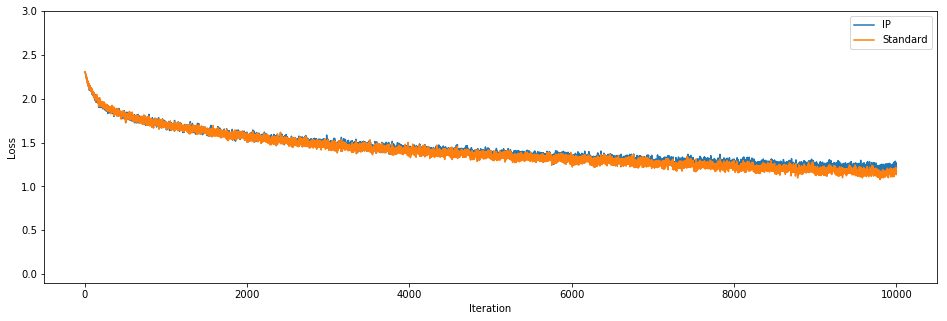

In [14]:
syn_lr = 0.0006

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 2.053
[2] loss: 1.904
[3] loss: 1.848
[4] loss: 1.806
[5] loss: 1.760
[6] loss: 1.738
[7] loss: 1.712
[8] loss: 1.676
[9] loss: 1.658
[10] loss: 1.630
[11] loss: 1.615
[12] loss: 1.582
[13] loss: 1.570
[14] loss: 1.557
[15] loss: 1.532
[16] loss: 1.531
[17] loss: 1.504
[18] loss: 1.491
[19] loss: 1.483
[20] loss: 1.461
[21] loss: 1.458
[22] loss: 1.443
[23] loss: 1.423
[24] loss: 1.427
[25] loss: 1.408
[26] loss: 1.396
[27] loss: 1.390
[28] loss: 1.382
[29] loss: 1.373
[30] loss: 1.369
[31] loss: 1.352
[32] loss: 1.355
[33] loss: 1.339
[34] loss: 1.329
[35] loss: 1.328
[36] loss: 1.316
[37] loss: 1.308
[38] loss: 1.293
[39] loss: 1.293
[40] loss: 1.280
Largest beta is  (tensor(1.1581, device='cuda:0'), tensor(61, device='cuda:0'))
Largest weight is  (tensor(1.1824, device='cuda:0'), tensor(102, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 2.099
[2] loss: 1.960
[3] loss: 1.874
[4] loss: 1.816
[5] loss: 1.786
[6] loss: 1.75

[18] loss: 1.528
[19] loss: 1.524
[20] loss: 1.511
[21] loss: 1.508
[22] loss: 1.489
[23] loss: 1.498
[24] loss: 1.476
[25] loss: 1.471
[26] loss: 1.461
[27] loss: 1.450
[28] loss: 1.442
[29] loss: 1.429
[30] loss: 1.434
[31] loss: 1.417
[32] loss: 1.408
[33] loss: 1.412
[34] loss: 1.399
[35] loss: 1.396
[36] loss: 1.385
[37] loss: 1.380
[38] loss: 1.375
[39] loss: 1.349
[40] loss: 1.350
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.6749, device='cuda:0'), tensor(95, device='cuda:0'))
Finished training!

Training IP Net. Run 6
[1] loss: 2.059
[2] loss: 1.893
[3] loss: 1.840
[4] loss: 1.790
[5] loss: 1.758
[6] loss: 1.744
[7] loss: 1.715
[8] loss: 1.677
[9] loss: 1.658
[10] loss: 1.636
[11] loss: 1.618
[12] loss: 1.592
[13] loss: 1.572
[14] loss: 1.545
[15] loss: 1.549
[16] loss: 1.527
[17] loss: 1.510
[18] loss: 1.498
[19] loss: 1.491
[20] loss: 1.466
[21] loss: 1.455
[22] loss: 1.445
[23] loss: 1.434
[24] loss: 1.426
[25] loss:

[37] loss: 1.350
[38] loss: 1.342
[39] loss: 1.335
[40] loss: 1.334
Largest beta is  (tensor(1.1509, device='cuda:0'), tensor(60, device='cuda:0'))
Largest weight is  (tensor(0.9555, device='cuda:0'), tensor(55, device='cuda:0'))
Finished training!

Training Standard Net. Run 10
[1] loss: 2.061
[2] loss: 1.914
[3] loss: 1.838
[4] loss: 1.799
[5] loss: 1.766
[6] loss: 1.734
[7] loss: 1.721
[8] loss: 1.688
[9] loss: 1.679
[10] loss: 1.645
[11] loss: 1.631
[12] loss: 1.610
[13] loss: 1.598
[14] loss: 1.579
[15] loss: 1.570
[16] loss: 1.551
[17] loss: 1.551
[18] loss: 1.533
[19] loss: 1.527
[20] loss: 1.520
[21] loss: 1.512
[22] loss: 1.500
[23] loss: 1.487
[24] loss: 1.486
[25] loss: 1.474
[26] loss: 1.468
[27] loss: 1.448
[28] loss: 1.449
[29] loss: 1.430
[30] loss: 1.437
[31] loss: 1.425
[32] loss: 1.408
[33] loss: 1.405
[34] loss: 1.387
[35] loss: 1.392
[36] loss: 1.376
[37] loss: 1.380
[38] loss: 1.370
[39] loss: 1.363
[40] loss: 1.347
Largest beta is  (tensor(0., device='cuda:0'), te

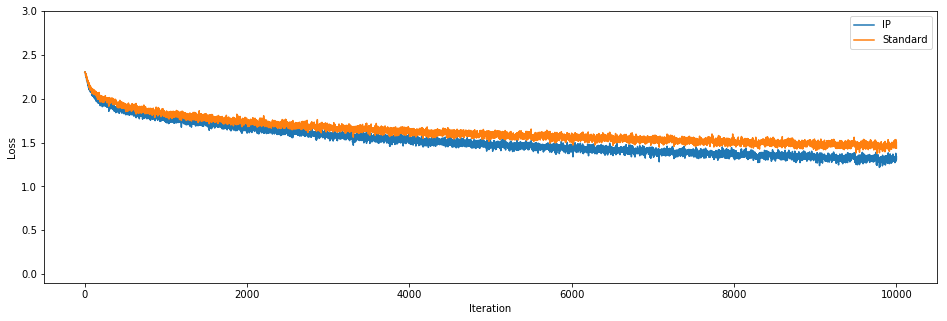

In [15]:
syn_lr = 0.001
run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 2.037
[2] loss: 1.913
[3] loss: 1.856
[4] loss: 1.812
[5] loss: 1.797
[6] loss: 1.761
[7] loss: 1.739
[8] loss: 1.722
[9] loss: 1.702
[10] loss: 1.679
[11] loss: 1.652
[12] loss: 1.639
[13] loss: 1.616
[14] loss: 1.608
[15] loss: 1.593
[16] loss: 1.574
[17] loss: 1.566
[18] loss: 1.556
[19] loss: 1.553
[20] loss: 1.541
[21] loss: 1.530
[22] loss: 1.521
[23] loss: 1.510
[24] loss: 1.500
[25] loss: 1.489
[26] loss: 1.488
[27] loss: 1.476
[28] loss: 1.461
[29] loss: 1.461
[30] loss: 1.450
[31] loss: 1.439
[32] loss: 1.442
[33] loss: 1.424
[34] loss: 1.430
[35] loss: 1.406
[36] loss: 1.402
[37] loss: 1.391
[38] loss: 1.385
[39] loss: 1.387
[40] loss: 1.373
Largest beta is  (tensor(1.1697, device='cuda:0'), tensor(2, device='cuda:0'))
Largest weight is  (tensor(1.3140, device='cuda:0'), tensor(95, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 2.097
[2] loss: 1.959
[3] loss: 1.899
[4] loss: 1.865
[5] loss: 1.858
[6] loss: 1.824


[18] loss: 1.636
[19] loss: 1.623
[20] loss: 1.610
[21] loss: 1.614
[22] loss: 1.603
[23] loss: 1.606
[24] loss: 1.584
[25] loss: 1.583
[26] loss: 1.574
[27] loss: 1.570
[28] loss: 1.564
[29] loss: 1.562
[30] loss: 1.557
[31] loss: 1.557
[32] loss: 1.551
[33] loss: 1.548
[34] loss: 1.545
[35] loss: 1.538
[36] loss: 1.529
[37] loss: 1.531
[38] loss: 1.515
[39] loss: 1.515
[40] loss: 1.514
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.9436, device='cuda:0'), tensor(16, device='cuda:0'))
Finished training!

Training IP Net. Run 6
[1] loss: 2.132
[2] loss: 2.011
[3] loss: 1.929
[4] loss: 1.897
[5] loss: 1.866
[6] loss: 1.855
[7] loss: 1.825
[8] loss: 1.808
[9] loss: 1.779
[10] loss: 1.771
[11] loss: 1.753
[12] loss: 1.738
[13] loss: 1.726
[14] loss: 1.705
[15] loss: 1.693
[16] loss: 1.674
[17] loss: 1.667
[18] loss: 1.657
[19] loss: 1.644
[20] loss: 1.634
[21] loss: 1.623
[22] loss: 1.613
[23] loss: 1.592
[24] loss: 1.589
[25] loss:

[35] loss: 1.404
[36] loss: 1.410
[37] loss: 1.394
[38] loss: 1.391
[39] loss: 1.381
[40] loss: 1.372
Largest beta is  (tensor(1.1637, device='cuda:0'), tensor(24, device='cuda:0'))
Largest weight is  (tensor(1.0134, device='cuda:0'), tensor(84, device='cuda:0'))
Finished training!

Training Standard Net. Run 10
[1] loss: 2.072
[2] loss: 1.917
[3] loss: 1.892
[4] loss: 1.854
[5] loss: 1.820
[6] loss: 1.804
[7] loss: 1.773
[8] loss: 1.753
[9] loss: 1.739
[10] loss: 1.721
[11] loss: 1.709
[12] loss: 1.686
[13] loss: 1.690
[14] loss: 1.669
[15] loss: 1.671
[16] loss: 1.646
[17] loss: 1.634
[18] loss: 1.627
[19] loss: 1.632
[20] loss: 1.603
[21] loss: 1.613
[22] loss: 1.597
[23] loss: 1.595
[24] loss: 1.581
[25] loss: 1.573
[26] loss: 1.568
[27] loss: 1.563
[28] loss: 1.547
[29] loss: 1.557
[30] loss: 1.560
[31] loss: 1.547
[32] loss: 1.537
[33] loss: 1.550
[34] loss: 1.538
[35] loss: 1.528
[36] loss: 1.528
[37] loss: 1.527
[38] loss: 1.519
[39] loss: 1.516
[40] loss: 1.513
Largest beta is

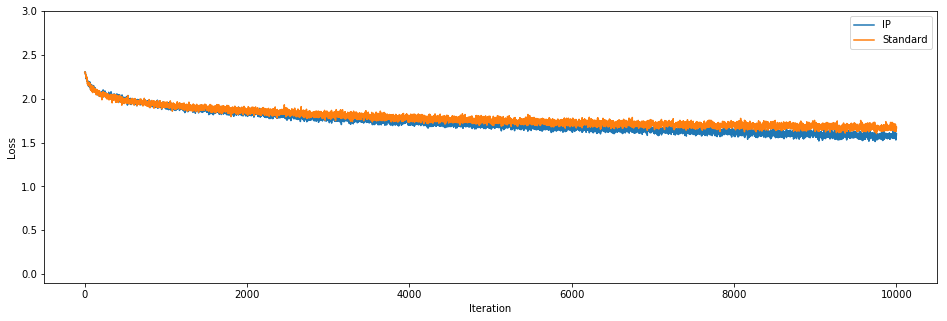

In [7]:
syn_lr = 0.0013

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)